In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torch.optim import Adam, RMSprop
from tqdm import tqdm

from generator import Generator
from discriminator import Discriminator
from graph import structured_adj_matrix
from scm import SCM
from custom_types import GraphType, FunctionType

plt.rcParams['figure.dpi'] = 100

In [2]:
def eval(X, g, d, batch_size=256, num_epochs=128):
    g_opt = Adam(g.parameters(), lr=2e-3, betas=(0.5, 0.999))
    d_opt = Adam(d.parameters(), lr=1e-3, betas=(0.5, 0.999))
    bce = nn.BCELoss()

    num_batches = X.shape[0] // batch_size
    p = [[] for _ in range(num_nodes**2)]
    g_losses, d_losses = [], []

    random_idxs = list(range(num_nodes))
    random_idxs = [-1] + random_idxs

    for k in (pbar := tqdm(range(num_epochs))):
        random.shuffle(random_idxs)
        for i in random_idxs:
            do_idx = i
            for j in range(num_batches):
                # train generator
                g_opt.zero_grad()
                z = torch.randn(batch_size, g.num_nodes)
                X_g, A = g(z, do_idx if do_idx >= 0 else None)
                preds = d(X_g)
                y_real = torch.ones(batch_size, 1)
                m_exp = torch.trace(torch.matrix_exp(torch.sigmoid(g.edge_beliefs.p.T))) - g.num_nodes
                if k <= 0.75 * num_epochs:
                    #g_loss = bce(preds, y_real) + 0.1*A.sum((1,2)).mean()
                    #g_loss = bce(preds, y_real) + A.sum((1,2)).mean() / g.num_nodes**2
                    g_loss = bce(preds, y_real) + A.mean()
                else:
                    g_loss = bce(preds, y_real) + m_exp
                g_loss.backward()
                g_opt.step()

                # train discriminator
                d_opt.zero_grad()
                z = torch.randn(batch_size, g.num_nodes)
                X_g, A = g(z, do_idx if do_idx >= 0 else None)
                X_data = X[j*batch_size:j*batch_size+batch_size]
                X_all = torch.cat((X_g, X_data)).float()
                preds = d(X_all)
                y_fake = torch.zeros(batch_size, 1)
                y_real = torch.ones_like(y_fake)
                y = torch.cat((y_fake, y_real))
                d_loss = bce(preds, y)
                d_loss.backward()
                d_opt.step()

                for r in range(g.num_nodes):
                    for c in range(g.num_nodes):
                        belief = torch.sigmoid(g.edge_beliefs.p.T[r,c]).item()
                        p[r*g.num_nodes+c].append(belief)
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
                
    return torch.sigmoid(g.edge_beliefs.p.T), g_losses, d_losses, p

In [3]:
def make_X(scm):
    X = np.zeros((0, 2*scm.num_nodes))
    for i in range(-1, scm.num_nodes):
        do = i if i >= 0 else None
        X_i = scm.sample(num_samples=1000, do=do)
        onehot = np.zeros_like(X_i)
        if do is not None: onehot[:, do] = 1
        X_i = np.concatenate((X_i, onehot), axis=1)
        X = np.concatenate((X, X_i))
    np.random.shuffle(X)
    return torch.tensor(X)

100%|██████████| 128/128 [00:37<00:00,  3.42it/s]


SHD (2 nodes): 0


100%|██████████| 128/128 [01:25<00:00,  1.50it/s]


SHD (3 nodes): 0


100%|██████████| 128/128 [02:44<00:00,  1.29s/it]


SHD (4 nodes): 0


100%|██████████| 128/128 [04:12<00:00,  1.97s/it]


SHD (5 nodes): 1


100%|██████████| 128/128 [06:31<00:00,  3.06s/it]


SHD (6 nodes): 0


100%|██████████| 128/128 [09:35<00:00,  4.49s/it]


SHD (7 nodes): 0


100%|██████████| 128/128 [13:31<00:00,  6.34s/it]


SHD (8 nodes): 2


100%|██████████| 128/128 [18:41<00:00,  8.76s/it]


SHD (9 nodes): 4


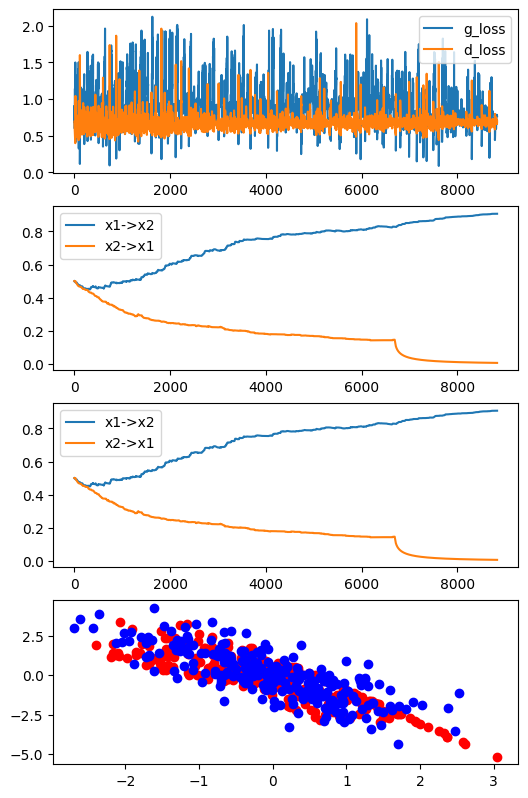

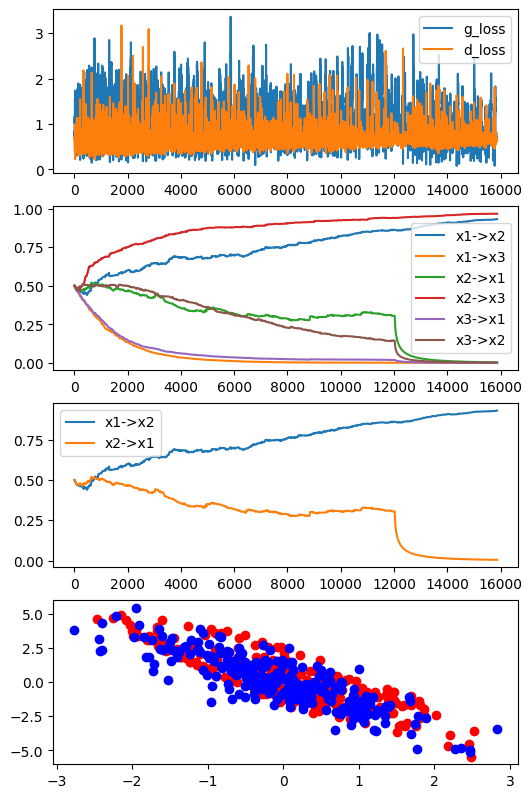

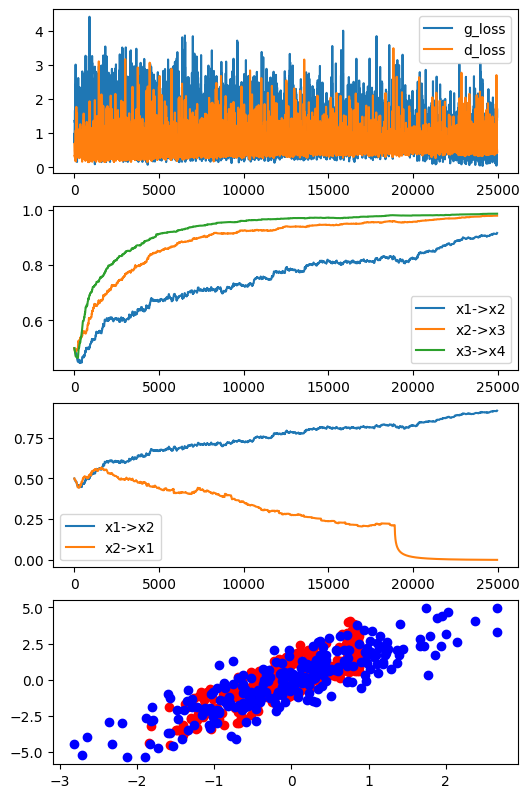

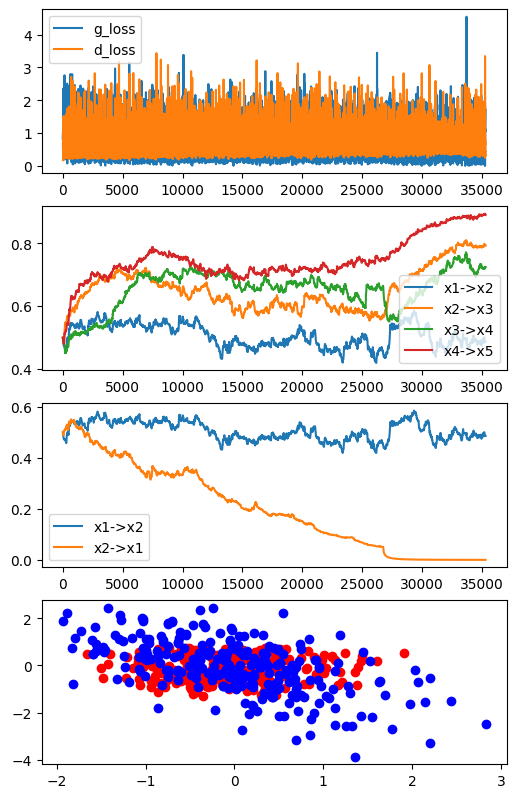

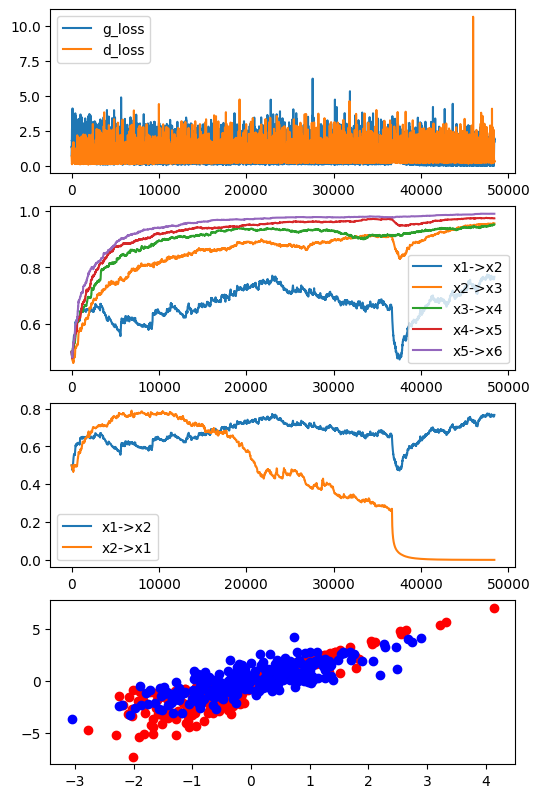

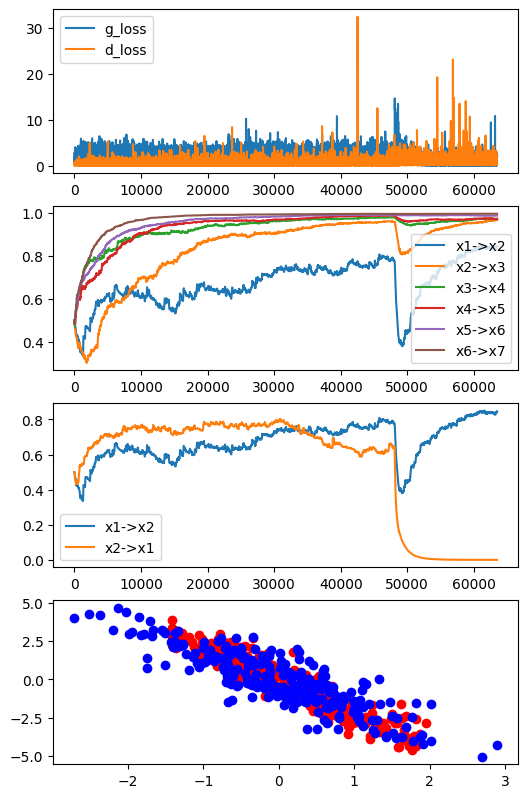

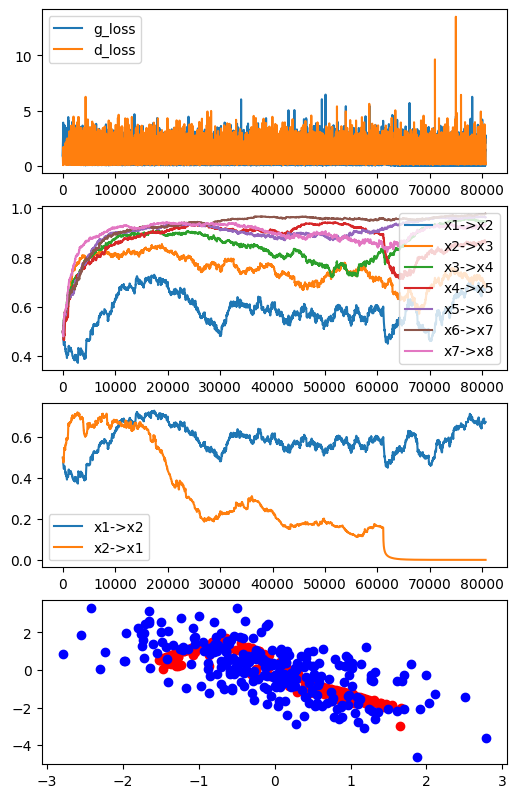

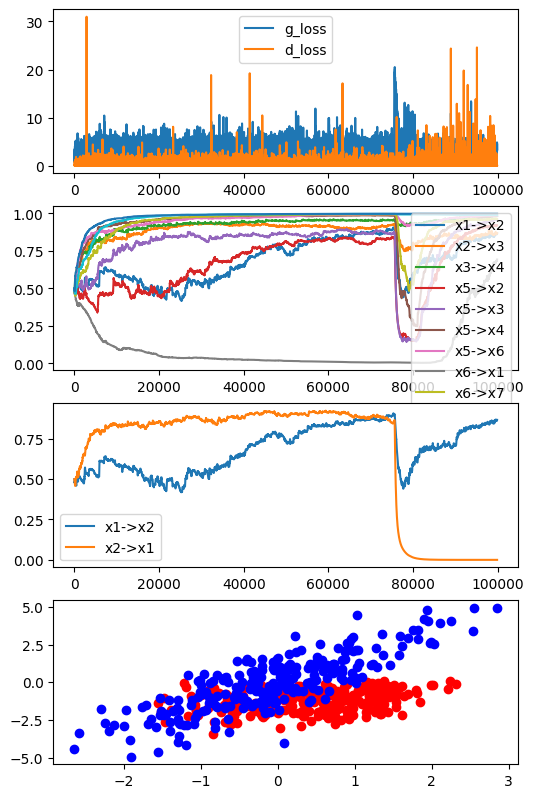

In [4]:
for i in range(2,10):
    num_nodes = i
    A = structured_adj_matrix(GraphType.CHAIN, num_nodes)
    scm = SCM(A, FunctionType.LINEAR)
    X = make_X(scm)
    g = Generator(num_nodes, num_dags=1, temperature=1)
    d = Discriminator(num_nodes)
    A_pred, g_losses, d_losses, p = eval(X, g, d, batch_size=128, num_epochs=128)
    A_pred = (A_pred > 0.7).detach().numpy()
    shd = np.count_nonzero(A-A_pred)
    print(f"SHD ({num_nodes} nodes):", shd)
    
    _, ax = plt.subplots(4, 1, figsize=(6,10))

    ax[0].plot(g_losses, label="g_loss")
    ax[0].plot(d_losses, label="d_loss")
    ax[0].legend()

    for r in range(num_nodes):
        for c in range(num_nodes):
            if r == c: continue
            if len(p) > 9 and p[r*num_nodes+c][-1] < 0.2: continue
            ax[1].plot(p[r*num_nodes+c], label=f"x{r+1}->x{c+1}")
    ax[1].legend()

    ax[2].plot(p[1], label="x1->x2")
    ax[2].plot(p[num_nodes], label="x2->x1")
    ax[2].legend()
    
    batch_size = 256
    z = torch.randn(batch_size, g.num_nodes)
    do = None

    X_g, A = g(z, do_idx=do)
    X_g = X_g.detach().numpy()
    X_data = scm.sample(batch_size, do=do)

    ax[3].scatter(X_g[:,0], X_g[:,1], c="r")
    ax[3].scatter(X_data[:,0], X_data[:,1], c="b")